In [1]:
# https://developers.google.com/optimization/introduction/python
# to do: 
# all or nothing flow - maximum one inflow and one outflow only (done)
# prune variables for the model (so that it is not 100k variables but 4k variables)
# add the const incurred on the difference between the largest and smallest cstcs
# plotting - reduce clutter

In [2]:
%reset -sf
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp
!sha1sum ../input/singapore-subzone-population/processed_dataframe.pkl
!pip freeze | grep ortools

e7a754fd2fbaa764f92a98a94080438670fe57b7  ../input/singapore-subzone-population/processed_dataframe.pkl
ortools==7.4.7247


# Define problem

In [3]:
df = pd.read_pickle("../input/singapore-subzone-population/processed_dataframe.pkl")
# df

In [4]:
for i,row in df.iterrows():
    if len(row["adjacent"]) != len(row["shared_param"]): print(i)

In [5]:
nodes = pd.DataFrame()
nodes["supplies"] = [max(2,z) for z in list(df["TOTAL"])]
nodes["x"] = df["x_centre"]
nodes["y"] = df["y_centre"]

start_nodes = []
end_nodes   = []
unit_costs  = []
for i,row in df.iterrows():
    for adj, cst in zip(row["adjacent"], row["shared_param"]):
        start_nodes.append(i)
        end_nodes.append(adj)
        unit_costs.append(np.around(cst,10))

edges = pd.DataFrame()
edges["start_nodes"] = start_nodes
edges["end_nodes"]   = end_nodes
edges["unit_costs"]  = unit_costs
edges["capacities"]  = [9999999]*len(start_nodes) # disabled
edges["flows"]       = [0]*len(start_nodes)
edges["flowing"]     = [0]*len(start_nodes)
edges["names"]       = "x"+edges[["start_nodes",
                                  "end_nodes"]].astype(str).apply('-'.join, axis=1)
edges.index = edges["names"]
N = len(nodes) # the number of nodes at init

In [6]:
edges.sample(5)

,start_nodes,end_nodes,unit_costs,capacities,flows,flowing,names
names,,,,,,,
x37-13,37,13,0.002163,9999999,0,0,x37-13
x194-202,194,202,0.010548,9999999,0,0,x194-202
x279-274,279,274,0.016360,9999999,0,0,x279-274
x37-2,37,2,0.001483,9999999,0,0,x37-2
x176-54,176,54,0.010849,9999999,0,0,x176-54


# Augment nodes to a common sink

In [7]:
def augment_nodes(nodes, edges):
    for i,ss in enumerate(nodes["supplies"]):
        edges.loc[len(edges)] = [i, N, 0, 9999999, 0, 0,
                                 "x"+str(i)+"-"+str(N)]
        edges.loc[len(edges)] = [N, i, 0, 9999999, 0, 0,
                                 "x"+str(N)+"-"+str(i)]
    nodes.loc[len(nodes)] = [-sum(nodes["supplies"]), 103.7, 1.1]
    edges.index = edges["names"]
    return nodes, edges

In [8]:
nodes, edges = augment_nodes(nodes, edges)
assert sum(nodes["supplies"]) == 0
# nodes
# edges

# Generate adjacency matrix

In [9]:
def get_adjacency_matrix(edges):
    start_nodes = edges["start_nodes"]
    end_nodes = edges["end_nodes"]
    unit_costs = edges["unit_costs"]
    capacities = edges["capacities"]
    flows = edges["flows"]
    flowing = edges["flowing"]
    names = edges["names"]
    
    matrix_unit_costs = [[0 for _ in range(N+1)] for _ in range(N+1)]
    matrix_capacities = [[0 for _ in range(N+1)] for _ in range(N+1)]
    matrix_flows      = [[0 for _ in range(N+1)] for _ in range(N+1)]
    matrix_flowing    = [[0 for _ in range(N+1)] for _ in range(N+1)]
    matrix_names      = [["x"+str(i)+"-"+str(j)
                          for i in range(N+1)] 
                         for j in range(N+1)]
    
    for x,y,z,c,f,g in zip(start_nodes, end_nodes, unit_costs, capacities, flows, flowing):
        matrix_unit_costs[x][y] = z
        matrix_capacities[x][y] = c
        matrix_flows     [x][y] = f
        matrix_flowing   [x][y] = g
        
    for y,x,z,c,f,g in zip(start_nodes, end_nodes, unit_costs, capacities, flows, flowing):
        matrix_unit_costs[x][y] = z
        matrix_capacities[x][y] = c
        matrix_flows     [x][y] = f
        matrix_flowing   [x][y] = g

    return matrix_unit_costs, matrix_capacities, matrix_flows, matrix_names, matrix_flowing

(matrix_unit_costs, matrix_capacities, 
 matrix_flows, matrix_names, matrix_flowing) = get_adjacency_matrix(edges)

In [10]:
# matrix_unit_costs, matrix_capacities, matrix_flows, matrix_names
assert np.all(np.array(matrix_capacities)[:N,:N] == np.transpose(matrix_capacities)[:N,:N])
assert np.all(np.array(matrix_unit_costs)[:N,:N] == np.transpose(matrix_unit_costs)[:N,:N])

# Visualisation

In [11]:
edges.sample(5)

,start_nodes,end_nodes,unit_costs,capacities,flows,flowing,names
names,,,,,,,
x316-269,316,269,0.008805,9999999,0,0,x316-269
x196-285,196,285,0.046323,9999999,0,0,x196-285
x91-84,91,84,0.007392,9999999,0,0,x91-84
x58-197,58,197,0.015183,9999999,0,0,x58-197
x18-48,18,48,0.008110,9999999,0,0,x18-48


In [12]:
def plot_graph(nodes, edges):
    start_nodes = edges["start_nodes"]
    end_nodes = edges["end_nodes"]
    unit_costs = edges["unit_costs"]
    capacities = edges["capacities"]
    flows = edges["flows"]
    names = edges["names"]

    G = nx.DiGraph()
    for x,y,z,c,f,n in zip(start_nodes, end_nodes, unit_costs, capacities, flows, names):
        G.add_edge(x, y, cost=z, capacity=c, flow=f, name=n)

    labeldict = {}
    for i,s in enumerate(nodes["supplies"]):
        labeldict[i] = int(s)

    fig, ax = plt.subplots(figsize=(14,14))
    
    pos=nx.circular_layout(G)
    pos={}
    for i,node in nodes.iterrows():
        pos[i] = [node["x"], node["y"]]
    
    for edge in G.edges(data=True):
        w = edge[2]['flow']
        if w > 0:
            size = np.log(1+w)
            nx.draw_networkx_edge_labels(G,pos, edgelist=[(edge[0],edge[1])], 
                                         edge_labels = {(edge[0],edge[1]): w})
            nx.draw_networkx_edges(G, pos, edgelist=[(edge[0],edge[1])], 
                                   width=size, arrowsize=size*10)
            
    nx.draw_networkx_nodes(G, pos, with_labels=True, font_size=15, 
                           node_size=200, 
                           node_color="yellow")
    nx.draw_networkx_labels(G, pos, labels=labeldict)
    
    ax.autoscale()
    ax.set_aspect(1)
    ax.margins(0.1)
    plt.show()

In [13]:
edges

,start_nodes,end_nodes,unit_costs,capacities,flows,flowing,names
names,,,,,,,
x0-40,0,40,0.010374,9999999,0,0,x0-40
x0-76,0,76,0.004139,9999999,0,0,x0-76
x0-21,0,21,0.010858,9999999,0,0,x0-21
x0-28,0,28,0.009546,9999999,0,0,x0-28
x1-35,1,35,0.001659,9999999,0,0,x1-35
...,...,...,...,...,...,...,...
x318-315,318,315,0.000000,9999999,0,0,x318-315
x316-318,316,318,0.000000,9999999,0,0,x316-318
x318-316,318,316,0.000000,9999999,0,0,x318-316


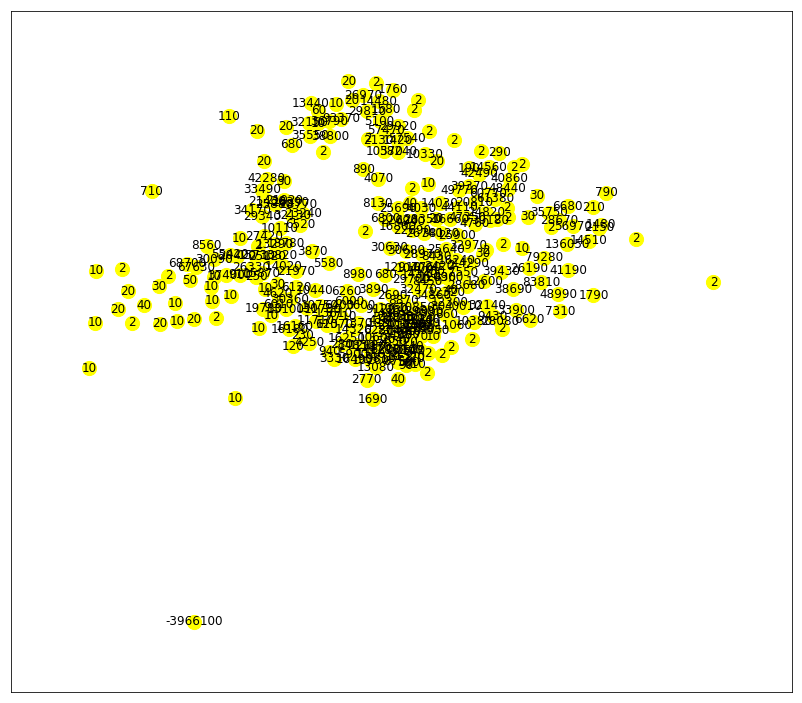

In [14]:
plt.show()
plot_graph(nodes, edges)

# Min-cost flow as a linear program

In [15]:
solver = pywraplp.Solver('hello_program',
                         pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

# define variables and capacities
infinity = solver.infinity()
X = [[solver.NumVar(0.0, matrix_capacities[i][j], 'x'+str(i)+"-"+str(j)) 
      for j in range(N+1)]
     for i in range(N+1)]

# define supplies
for i in range(N+1):
    solver.Add(sum([X[i][j] for j in range(N+1)])
             - sum([X[j][i] for j in range(N+1)])
            == nodes["supplies"][i])

In [16]:
B = [[solver.IntVar(0.0, 1.0, 'b'+str(i)+"-"+str(j)) 
      for j in range(N+1)]
     for i in range(N+1)]
U = solver.IntVar(0.0, 9999999, 'U')
L = solver.NumVar(0.0, 9999999, 'L')

In [17]:
%%time
NUM_CSTCS = 10
capacity_bound = int(sum(nodes["supplies"][:-1]//(NUM_CSTCS**0.5)))
print("capacity_bound", capacity_bound)
for i in range(N):
    for j in range(N+1):
        if matrix_capacities[i][j] > 0:
            solver.Add(X[i][j] <= B[i][j]*capacity_bound)
    # solver.Add(X[i][N] >= B[i][N]*10)  # could not add lower bound :/
    solver.Add(sum([B[i][j] for j in range(N+1)]) <= 1)
    solver.Add(U >= X[i][N])
    solver.Add(L <= X[i][N] + (1-B[i][N])*19999999)

capacity_bound 1254033
CPU times: user 1.59 s, sys: 0 ns, total: 1.59 s
Wall time: 1.59 s


In [18]:
sum(nodes["supplies"][:-1]//(1.5*NUM_CSTCS)), capacity_bound

(264301.0, 1254033)

In [19]:
# limit number of cstcs
solver.Add(sum(B[i][N] for i in range(N)) <= NUM_CSTCS)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x7f92365101e0> >

In [20]:
# define objective
solver.Minimize(sum([sum([matrix_unit_costs[i][j] * X[i][j]
                          for j in range(N+1)])
                     for i in range(N+1)])
#                 + sum([B[i][N] for i in range(N+1)])
#                 + U 
#                 - 2*L
)
solver.set_time_limit(15*1000)

print('Number of variables =', solver.NumVariables())
print('Number of constraints =', solver.NumConstraints())

Number of variables = 203524
Number of constraints = 3262


In [21]:
%%time
# print(solver.ExportModelAsLpFormat(False).replace('\\', '').replace(',_', ','), sep='\n')
status = solver.Solve()

CPU times: user 15.5 s, sys: 264 ms, total: 15.8 s
Wall time: 15.7 s


# Visualise output

In [22]:
if status == solver.NOT_SOLVED: print('Unsolved')
if status == solver.FEASIBLE:   print('Stopped by time limit')
if status == solver.OPTIMAL:    print('Optimal')
if status == solver.INFEASIBLE: print('Infeasible')
if status == solver.UNBOUNDED:  print('Unbounded')

Stopped by time limit


In [23]:
print('Solution:')
print('Objective value =', solver.Objective().Value())
print('')
print('Advanced usage:')
print('Problem solved in %f milliseconds' % solver.wall_time())
print('Problem solved in %d iterations'   % solver.iterations())
print('Problem solved in %d branch-and-bound nodes' % solver.nodes())
print('Number of cstcs %i' % sum(B[i][N].solution_value() for i in range(N+1)))
# print('Bounds of cstcs', U.solution_value(), L.solution_value())

Solution:
Objective value = 87924.38955059978

Advanced usage:
Problem solved in 24065.000000 milliseconds
Problem solved in 4255 iterations
Problem solved in 191 branch-and-bound nodes
Number of cstcs 10


In [24]:
matrix_flows = [[x.solution_value() for x in xxx] for xxx in X]
matrix_flowing = [[b.solution_value() for b in bbb] for bbb in B]
for i,row in enumerate(matrix_flows):
    for j,cell in enumerate(row):
        if matrix_flows[i][j] > 0:
            edges.at["x"+str(i)+"-"+str(j),"flows"] = matrix_flows[i][j]
            edges.at["x"+str(i)+"-"+str(j),"flowing"] = matrix_flowing[i][j]
edges.to_pickle("edges.pkl")

# Visualisation of results

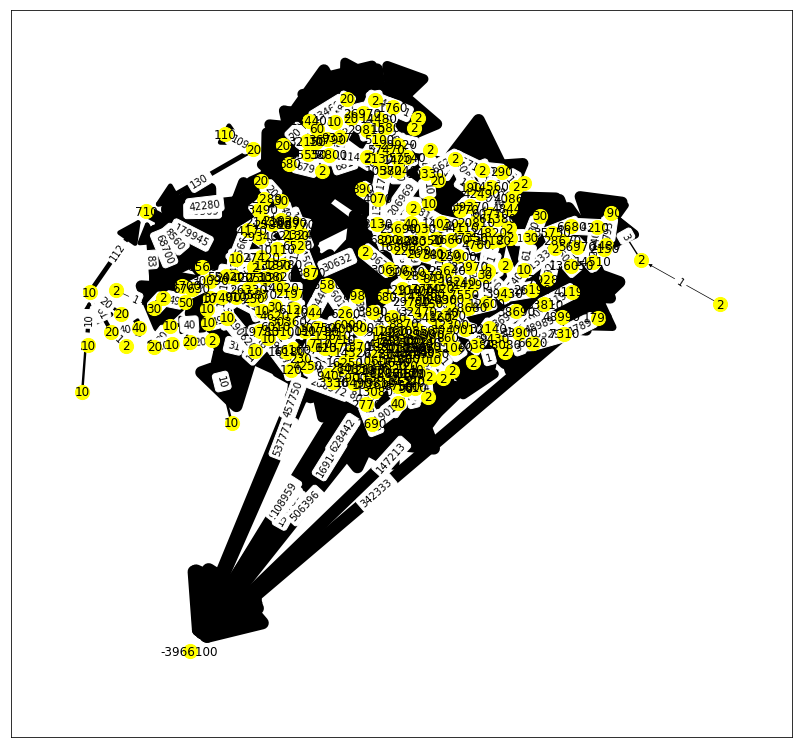

In [25]:
plot_graph(nodes, edges)

In [26]:
edges.tail(10)

,start_nodes,end_nodes,unit_costs,capacities,flows,flowing,names
names,,,,,,,
x313-318,313,318,0.0,9999999,0,0,x313-318
x318-313,318,313,0.0,9999999,0,0,x318-313
x314-318,314,318,0.0,9999999,0,0,x314-318
x318-314,318,314,0.0,9999999,0,0,x318-314
x315-318,315,318,0.0,9999999,0,0,x315-318
x318-315,318,315,0.0,9999999,0,0,x318-315
x316-318,316,318,0.0,9999999,0,0,x316-318
x318-316,318,316,0.0,9999999,0,0,x318-316
x317-318,317,318,0.0,9999999,0,0,x317-318


In [27]:
edges.tail(318).head(10)

,start_nodes,end_nodes,unit_costs,capacities,flows,flowing,names
names,,,,,,,
x159-318,159,318,0.0,9999999,0,0,x159-318
x318-159,318,159,0.0,9999999,0,0,x318-159
x160-318,160,318,0.0,9999999,0,0,x160-318
x318-160,318,160,0.0,9999999,0,0,x318-160
x161-318,161,318,0.0,9999999,0,0,x161-318
x318-161,318,161,0.0,9999999,0,0,x318-161
x162-318,162,318,0.0,9999999,0,0,x162-318
x318-162,318,162,0.0,9999999,0,0,x318-162
x163-318,163,318,0.0,9999999,0,0,x163-318


In [28]:
edges[edges["flows"]>0]\
.sort_values(by="start_nodes", ascending=False)\
.sort_values(by="end_nodes", kind='mergesort')

,start_nodes,end_nodes,unit_costs,capacities,flows,flowing,names
names,,,,,,,
x39-1,39,1,0.003097,9999999,85629,1,x39-1
x38-1,38,1,0.002066,9999999,1499,1,x38-1
x33-1,33,1,0.007406,9999999,320,1,x33-1
x34-3,34,3,0.005107,9999999,1149,1,x34-3
x41-6,41,6,0.003001,9999999,16199,1,x41-6
...,...,...,...,...,...,...,...
x129-318,129,318,0.000000,9999999,506396,1,x129-318
x118-318,118,318,0.000000,9999999,342333,1,x118-318
x79-318,79,318,0.000000,9999999,914809,1,x79-318


308


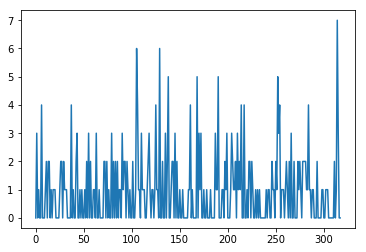

In [29]:
arr = [sum([r > 0 for r in row]) for row in np.transpose(matrix_flows)][:-1]
print(sum(arr))
plt.plot(arr)
plt.show()

308.0


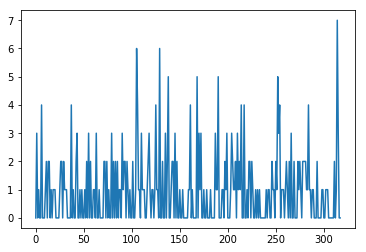

In [30]:
arr = [sum(row) for row in np.transpose(matrix_flowing)][:-1]
print(sum(arr))
plt.plot(arr)
plt.show()

318


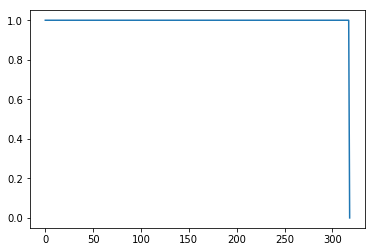

In [31]:
arr = [sum([r > 0 for r in row]) for row in matrix_flows]
print(sum(arr))
plt.plot(arr)
plt.show()

0.0
318.0


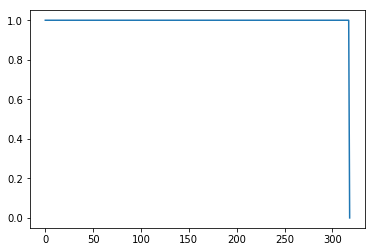

In [32]:
arr = [sum(row) for row in matrix_flowing]
print(arr[-1])
print(sum(arr))
plt.plot(arr)
plt.show()

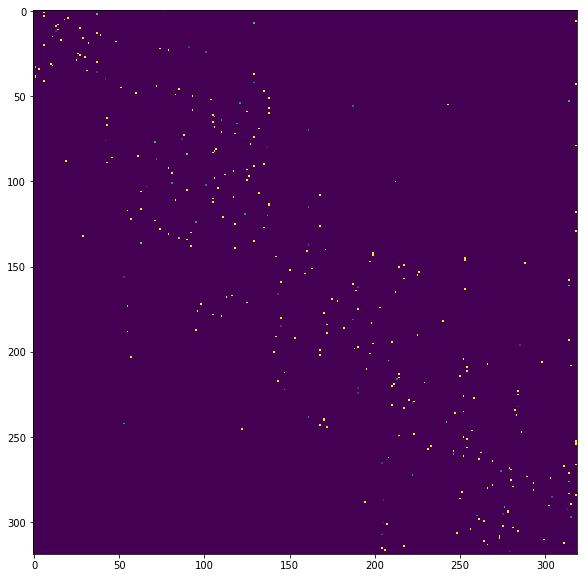

In [33]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(10,10))
plt.imshow(np.array(matrix_flows)+1,
           norm=LogNorm(vmin=1, vmax=np.sqrt(1+np.max(matrix_flows))))
plt.show()

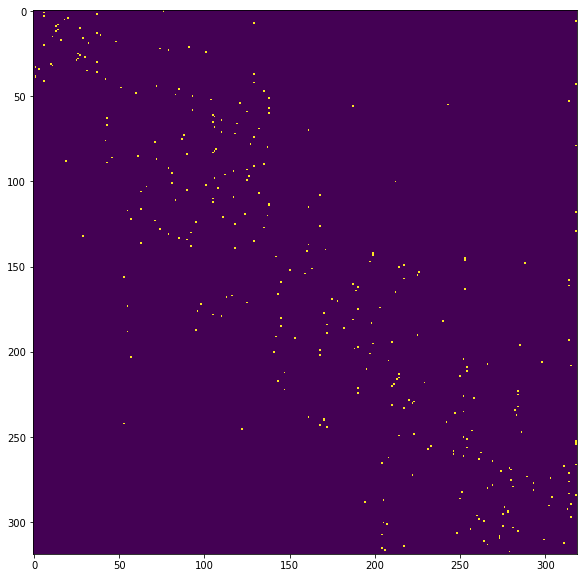

In [34]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(10,10))
plt.imshow(matrix_flowing)
plt.show()